In [ ]:
import datetime
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(style="darkgrid")
from datetime import datetime
import cvxpy as cp  
import scipy.optimize as sco
import numpy as np
#from arch import arch_model
#import empyrical as ep
from sklearn.covariance import LedoitWolf, MinCovDet
from pandas_datareader import data as wb
import time

In [ ]:
X=np.load("/content/drive/MyDrive/NIFTY 50 Dataset/Processed Data/X_1200.npy")
rb=np.load("/content/drive/MyDrive/NIFTY 50 Dataset/Processed Data/rb_1200.npy")

In [ ]:
X.shape

(1200, 49)

In [ ]:
rb.shape

(1200,)

In [ ]:
where_X_is_NaN=np.isnan(X)
where_rb_is_NaN=np.isnan(rb)

In [ ]:
#where_X_is_valid=np.logical_not(where_X_is_NaN)
#where_rb_is_valid=np.logical_not(where_rb_is_NaN)
X[where_X_is_NaN]=0
rb[where_rb_is_NaN]=0

T_test is the time period we want to hold the portfolio for.

In [ ]:
T=X.shape[0]
N=X.shape[1]
Aniket=0.5 #Aniket decides the proportion of Train data to Test Data

T_test= 240 #Decides the time we hold the portfolio for.
T_train=int(Aniket*T_test)

X_train=X[T_test:T_test+T_train,:]
X_test=X[:T_test,:]
X_train=np.flip(X_train)
X_test=np.flip(X_test)
rb_train=rb[T_test:T_test+T_train]
rb_test=rb[:T_test]
rb_train=np.flip(rb_train)
rb_test=np.flip(rb_test)

In [ ]:
start=time.time()
gamma = 0.4
p = 1e-3  # parameters for the rho approximation of log
lamb = 1e-6  # lambda is proportional to sparsity
N = 49
# MM loop

w = np.ones(N)/N

obj_value = np.array([1/T_train * np.linalg.norm(rb_train - X_train @ w)**2 + lamb * np.sum(np.log(1+np.abs(w)/p)/np.log(1+gamma/p))])

while(True):
                  
    d = 1/(np.log(1+gamma/p)*(p+w))
    w_prev = w     
    
    w = cp.Variable(N,nonneg=True)
    obj = cp.Minimize(1/T_train * cp.sum_squares(rb_train - X_train @ w) + lamb * d @ w)
                      
    prob = cp.Problem(obj, constraints = [w >= 0, cp.sum(w) == 1])
    result = prob.solve()   
    w = w.value
           
    obj_value = np.append(obj_value, 1/T_train * np.linalg.norm(rb_train - X_train @ w)**2 + lamb * np.sum(np.log(1+np.abs(w)/p)/np.log(1+gamma/p)))
  
    if(np.linalg.norm(w-w_prev)/np.linalg.norm(w_prev) < 1e-4):
        break

w_MM_single = w
end=time.time()
running_time=end-start

In [ ]:
N_Optimized=np.count_nonzero(w_MM_single)
print(f"N_Optimized:{N_Optimized}",N_Optimized)
print(w_MM_single)
print(f"Running time:{running_time}")

N_Optimized:24 24
[2.24928813e-23 0.00000000e+00 1.01827399e-22 0.00000000e+00
 0.00000000e+00 4.55817338e-02 7.39331993e-02 1.65725711e-01
 0.00000000e+00 0.00000000e+00 8.48836303e-23 0.00000000e+00
 0.00000000e+00 8.56539425e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.33944532e-23 0.00000000e+00 0.00000000e+00
 7.58958331e-02 0.00000000e+00 0.00000000e+00 7.19210197e-02
 0.00000000e+00 1.84514404e-22 7.91798339e-23 1.22324509e-01
 0.00000000e+00 0.00000000e+00 4.62736846e-02 1.69310179e-01
 7.57267448e-24 0.00000000e+00 1.31413559e-22 0.00000000e+00
 2.30604195e-02 8.46526143e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.48845893e-23 3.56671545e-02
 8.45310243e-23 1.62954074e-22 0.00000000e+00 0.00000000e+00
 1.92662531e-22]
Running time:0.19282031059265137


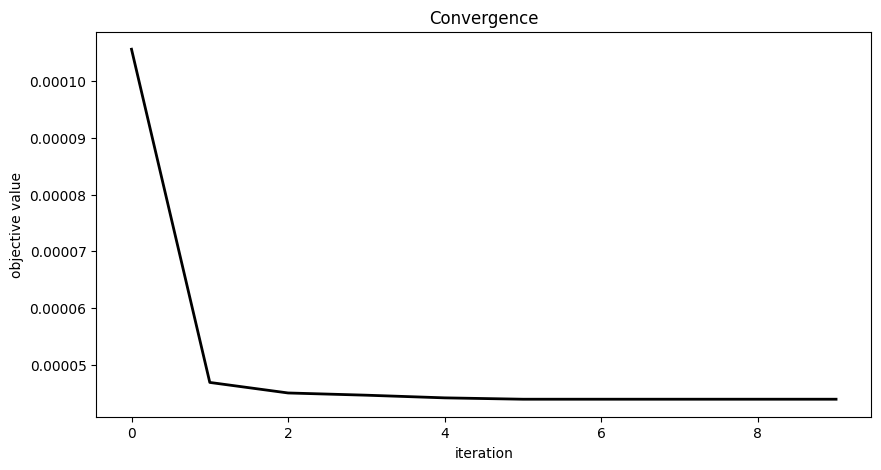

In [ ]:
plt.figure(figsize=(10,5))

plt.plot(obj_value, lw=2, color='k')
plt.title('Convergence')
plt.xlabel('iteration')
plt.ylabel('objective value')
plt.savefig(f'/content/drive/MyDrive/NIFTY 50 Dataset/Plots/Model 1 Convergence for T={T_test}.jpg')

#Tracking Error

In [ ]:
train_error=(1/T_train)*np.linalg.norm(rb_train - X_train @ w_MM_single)**2
test_error=(1/T_test)*np.linalg.norm(rb_test - X_test @ w_MM_single)**2

In [ ]:
print(f"Train Error:{train_error}",train_error)
print(f"Test Error:{test_error}",test_error)

Train Error:3.5303815376634284e-05 3.5303815376634284e-05
Test Error:2.1785618599134457e-05 2.1785618599134457e-05


In [ ]:
returns_mm_train = X_train @ w_MM_single
returns_mm_test = X_test @ w_MM_single
rb_train=np.flip(rb_train)
rb_test=np.flip(rb_test)

In [ ]:
mm_PnL_train= np.array([1])
mm_PnL_test=np.array([1])
rb_PnL_train=np.array([1])
rb_PnL_test=np.array([1])
for i in returns_mm_train:
    mm_PnL_train = np.append(mm_PnL_train, mm_PnL_train[-1]*np.exp(i))
for i in returns_mm_test:
    mm_PnL_test = np.append(mm_PnL_test, mm_PnL_test[-1]*np.exp(i))
for i in rb_train:
    rb_PnL_train = np.append(rb_PnL_train, rb_PnL_train[-1]*np.exp(i))
for i in rb_test:
    rb_PnL_test = np.append(rb_PnL_test, rb_PnL_test[-1]*np.exp(i))


Plotting Tracked value vs Real value during training

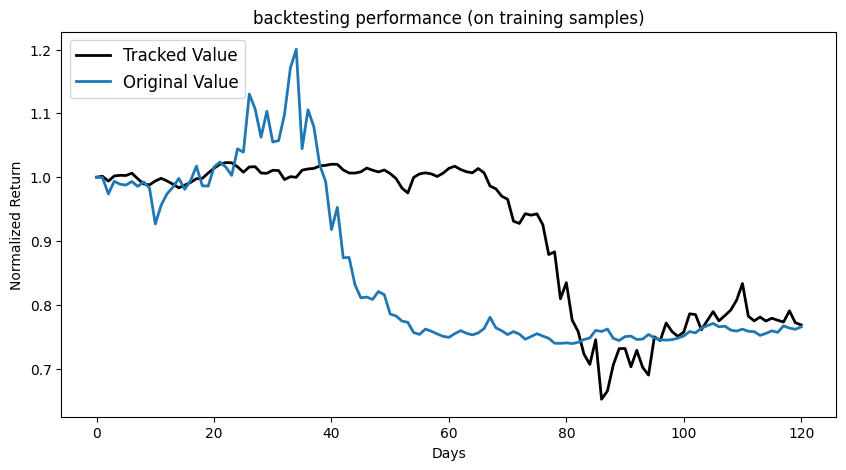

In [ ]:
plt.figure(figsize=(10,5))

plt.plot(mm_PnL_train, label='Tracked Value', lw=2, color='k')
plt.plot(rb_PnL_train, label='Original Value', lw=2)

plt.legend(loc='upper left', fontsize=12)
plt.title('backtesting performance (on training samples)')
plt.xlabel('Days')
plt.ylabel('Normalized Return')
plt.savefig(f'/content/drive/MyDrive/NIFTY 50 Dataset/Plots/Model 1 Training for T={T_test}.jpg')

Plotting Tracked value vs Real value during testing

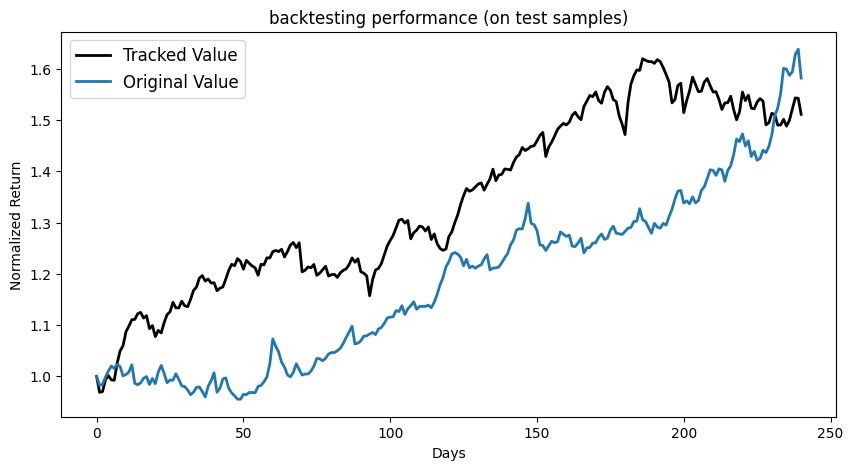

In [ ]:
plt.figure(figsize=(10,5))

plt.plot(mm_PnL_test, label='Tracked Value', lw=2, color='k')
plt.plot(rb_PnL_test, label='Original Value', lw=2)

plt.legend(loc='upper left', fontsize=12)
plt.title('backtesting performance (on test samples)')
plt.xlabel('Days')
plt.ylabel('Normalized Return')
plt.savefig(f'/content/drive/MyDrive/NIFTY 50 Dataset/Plots/Model 1 Testing for T={T_test}.jpg')